For my spring quarter rotation project with Risa, I'm going to be building an emulator for Galaxy statistics. I'm starting, though, by populating mocks with HODs. The package halotools makes this very easy. I'm first going to just run the simple example with the built-ins that they have. After that I'll attmempt to make my modifications to that by adding a parameter. 

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from halotools.empirical_models import HodModelFactory

In [3]:
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model = Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

In [4]:
from halotools.empirical_models import NFWPhaseSpace, Zheng07Sats
sats_occ_model = Zheng07Sats()
sats_prof_model = NFWPhaseSpace()

In [5]:
model_instance = HodModelFactory(
        centrals_occupation = cens_occ_model,
        centrals_profile = cens_prof_model,
        satellites_occupation = sats_occ_model,
        satellites_profile = sats_prof_model)

In [6]:
from halotools.sim_manager import CachedHaloCatalog
halocat= CachedHaloCatalog(simname = 'multidark', halo_finder = 'rockstar',
                          redshift = 0)

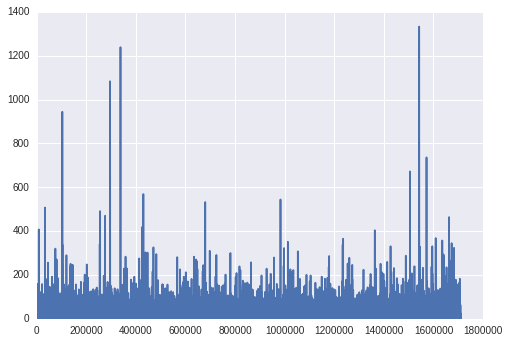

In [11]:
plt.plot(halocat.halo_table['halo_nfw_conc'])

In [7]:
model_instance.populate_mock(halocat)

In [8]:
halo_mass = np.logspace(11,14,100)

mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)

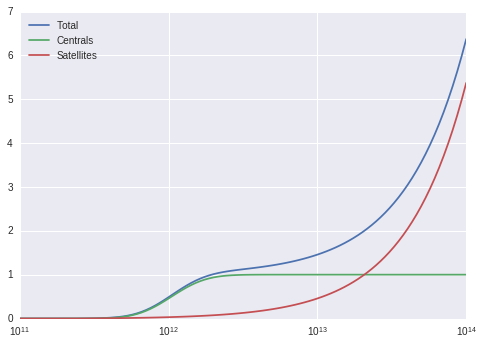

In [9]:
plt.plot(halo_mass, mean_ncen+mean_nsat, label = 'Total')
plt.plot(halo_mass,mean_ncen, label = 'Centrals')
plt.plot(halo_mass,mean_nsat, label = 'Satellites')
plt.xscale('log')

plt.legend(loc = 'best')

In [10]:
class RedMagicCens(Zheng07Cens):
    """Slight tweak of the Zheng model to add a new parameter, f_c
    """
    #TODO what meaning does Luminosity threshold hold here?
    def __init__(self,**kwargs):
        
        upper_occupation_bound = 1.0
        super(RedMagicCens,self).__init__(**kwargs)
        
        if 'f_c' not in self.param_dict:
            self.param_dict['f_c'] = 0.19 #add in best fit of new param.
        
    def mean_occupation(self, **kwargs):
        "See Zheng07 for details"
        return self.param_dict['f_c']*super(RedMagicCens,self).mean_occupation(**kwargs)
    
class RedMagicSats(Zheng07Sats):
    "Slight tweak of Zheng model to add new parameter, f_c"
    
    def __init__(self, **kwargs):
        
        upper_occupation_bound = float("inf")
        super(RedMagicSats,self).__init__(**kwargs)
        
        #TODO not sure if this will work for the whole model; will need to test
        #may need to 'modulate'
        #if 'f_c' not in self.param_dict:
        #    self.param_dict['f_c'] = 0.19 #add in best fit of new param.
        
    def mean_occupation(self, **kwargs):
        "See Zheng07 for details"
        f_c = 1
        if 'f_c' in self.param_dict:
            f_c = self.param_dict['f_c']
        
        return super(RedMagicSats,self).mean_occupation(**kwargs)/f_c
    

In [11]:
rz = 0.5
cens_prof_model = TrivialPhaseSpace(redshift = rz)
sats_prof_model = NFWPhaseSpace(redshift = rz)
model_instance = HodModelFactory(
        centrals_occupation = RedMagicCens(redshift = rz),
        centrals_profile = cens_prof_model,
        satellites_occupation = RedMagicSats(redshift = rz),
        satellites_profile = sats_prof_model)

In [12]:
halo_mass = np.logspace(11,13,100)

mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)

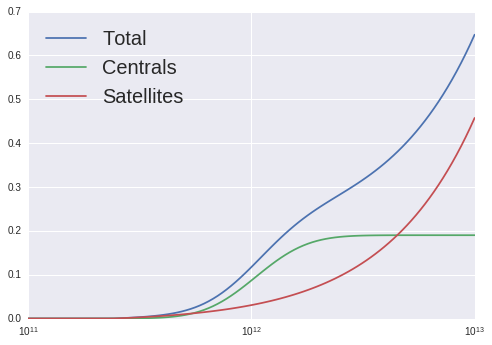

In [13]:
plt.plot(halo_mass, mean_ncen+mean_nsat, label = 'Total')
plt.plot(halo_mass,mean_ncen, label = 'Centrals')
plt.plot(halo_mass,mean_nsat, label = 'Satellites')
plt.xscale('log')

plt.legend(loc = 'best', fontsize = 20)

In [14]:
for key in model_instance.param_dict.keys():
    print key

logMmin
f_c
logM0
sigma_logM
logM1
alpha


In [15]:
from halotools.sim_manager import CachedHaloCatalog
halocat= CachedHaloCatalog(simname = 'multidark', halo_finder = 'rockstar',
                          redshift = 0.5)

In [16]:
model_instance.populate_mock(halocat)

In [17]:
model_instance.mock.galaxy_table.colnames

['halo_upid',
 'conc_NFWmodel',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rvir',
 'halo_mvir',
 'halo_id',
 'halo_num_satellites',
 'halo_num_centrals',
 'gal_type',
 'vx',
 'host_centric_distance',
 'vy',
 'y',
 'x',
 'vz',
 'z']

In [18]:
from halotools.mock_observables import return_xyz_formatted_array, tpcf, tpcf_one_two_halo_decomp
x, y, z = [model_instance.mock.galaxy_table[c] for c in ['x','y','z'] ]
pos = return_xyz_formatted_array(x,y,z)

rbins = np.logspace(-1, 1.25, 15)
rbin_centers = (rbins[1:]+rbins[:-1])/2

xi_all = tpcf(pos, rbins, period = model_instance.mock.Lbox, num_threads = 4)

halo_hostid = model_instance.mock.galaxy_table['halo_id']

xi_1h, xi_2h = tpcf_one_two_halo_decomp(pos,
                halo_hostid, rbins, 
                period = model_instance.mock.Lbox, num_threads = 4,
                max_sample_size = 1e7)

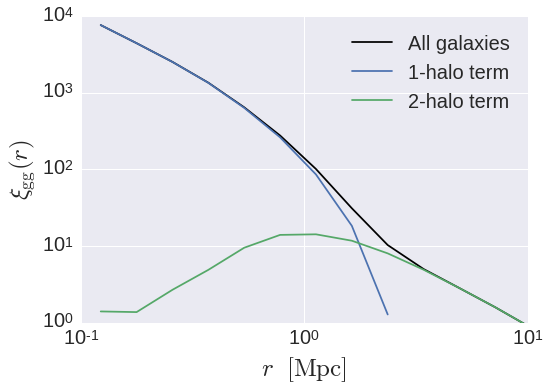

In [19]:
plt.plot(rbin_centers, xi_all,
         label='All galaxies', color='k')
plt.plot(rbin_centers, xi_1h,
         label = '1-halo term')
plt.plot(rbin_centers, xi_2h,
         label = '2-halo term')

plt.xlim(xmin = 0.1, xmax = 10)
plt.ylim(ymin = 1, ymax = 1e4)
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\xi_{\rm gg}(r)$', fontsize=25)
plt.legend(loc='best', fontsize=20)

In [20]:
from halotools.mock_observables import wp

pi_max = 40
rp_bins = np.logspace(-1,1.25,15)
wp_all = wp(pos, rp_bins, pi_max, period=model_instance.mock.Lbox, num_threads = 4)


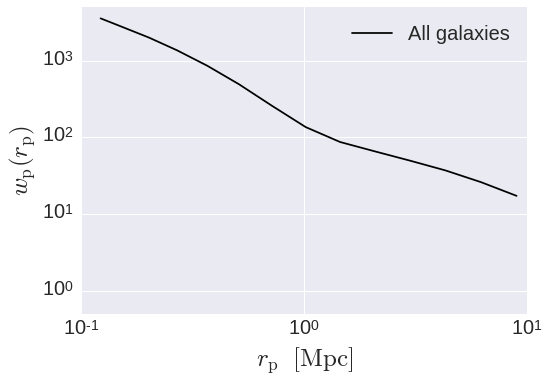

In [21]:
rp_bin_centers = (rp_bins[:1] + rp_bins[1:])/2.

plt.plot(rp_bin_centers, wp_all,
         label=r'All galaxies',
         color='k')

plt.xlim(xmin = 0.1, xmax = 10)
plt.ylim(ymin = 0.5, ymax = 5e3)
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r_{\rm p} $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$w_{\rm p}(r_{\rm p})$', fontsize=25)
plt.legend(loc='best', fontsize=20)

In [22]:
gals = model_instance.mock.galaxy_table

from halotools.utils import group_member_generator

gals.sort(['halo_id', 'halo_upid'])
grouping_key = 'halo_id'
requested_columns = ['halo_num_centrals', 'halo_num_satellites', 'halo_mvir']
group_gen = group_member_generator(gals, grouping_key, requested_columns)

ncen = []
nsat = []
mass = []

for first, last, member_props in group_gen:
    ncen.append(member_props[0][0])
    nsat.append(member_props[1][0])
    mass.append(member_props[2][0]) 
    
ncen = np.array(ncen)
nsat = np.array(nsat)
mass = np.array(mass)

In [23]:
from halotools.mock_observables import mean_y_vs_x
xmin, xmax = 1e11, 1e16
ymin, ymax = 0, 70
halo_mass = np.logspace(np.log10(xmin),np.log10(xmax),100)

binned_mass, ncen_hat, ncen_err= mean_y_vs_x(mass, ncen, bins = halo_mass, error_estimator = 'variance')
binned_mass, nsat_hat, nsat_err= mean_y_vs_x(mass, nsat, bins = halo_mass, error_estimator = 'variance')

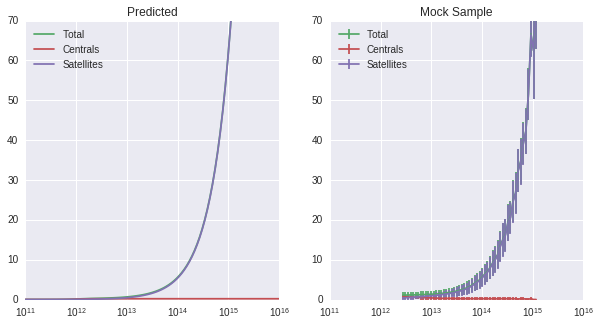

In [24]:
mean_ncen = model_instance.mean_occupation_centrals(prim_haloprop = halo_mass)
mean_nsat = model_instance.mean_occupation_satellites(prim_haloprop = halo_mass)

fig = plt.figure(figsize = (10,5))
colors = sns.color_palette()
plt.subplot(121)
plt.title("Predicted")
plt.plot(halo_mass, mean_ncen+mean_nsat,color = colors[1], label = 'Total')
plt.plot(halo_mass,mean_ncen,color = colors[2], label = 'Centrals')
plt.plot(halo_mass,mean_nsat,color = colors[3], label = 'Satellites')
plt.xscale('log')
plt.xlim([xmin,xmax])
plt.ylim([ymin, ymax])
plt.legend(loc = 'best', fontsize = 10)

plt.subplot(122)
plt.title("Mock Sample")
plt.errorbar(binned_mass, ncen_hat+nsat_hat,yerr = np.sqrt(ncen_err**2+nsat_err**2),
             color = colors[1],label = 'Total')
plt.errorbar(binned_mass,ncen_hat,yerr = ncen_err, color = colors[2], label = 'Centrals')
plt.errorbar(binned_mass,nsat_hat, yerr = nsat_err,color = colors[3], label = 'Satellites')
plt.xscale('log')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.legend(loc = 'best', fontsize = 10)

plt.show()

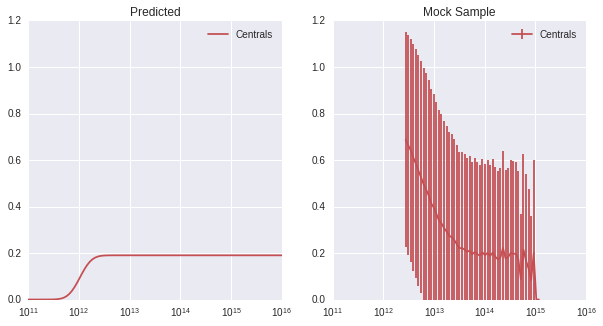

In [25]:
fig = plt.figure(figsize = (10,5))
colors = sns.color_palette()
plt.subplot(121)
plt.title("Predicted")
plt.plot(halo_mass,mean_ncen,color = colors[2], label = 'Centrals')
plt.xscale('log')
plt.xlim([xmin,xmax])
plt.ylim([0, 1.2])
plt.legend(loc = 'best', fontsize = 10)

plt.subplot(122)
plt.title("Mock Sample")
plt.errorbar(binned_mass,ncen_hat,yerr = ncen_err, color = colors[2], label = 'Centrals')
plt.xscale('log')
plt.xlim([xmin, xmax])
plt.ylim([0, 1.2])
plt.legend(loc = 'best', fontsize = 10)

plt.show()